In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

In [2]:
!pip install torch torchvision matplotlib numpy scikit-learn rsatoolbox scipy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.0/656.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.2 MB/s eta 0:00:00


In [ ]:
# @title Import dependencies

# Standard library imports
from collections import OrderedDict
import logging

# External libraries: General utilities
import argparse
import numpy as np

# PyTorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.utils import make_grid

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# SciPy for statistical functions
from scipy import stats

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# RSA toolbox specific imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

In [4]:
#@title Plotting functions

# @title Plotting functions

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outputs:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """

    with plt.xkcd():
        imgs, targets = next(iter(data_loader))

        imgs_o = []
        labels = []
        for value in range(10):
            cat_imgs = imgs[np.where(targets == value)][0:n]
            imgs_o.append(cat_imgs)
            labels.append([value]*len(cat_imgs))

        imgs = torch.cat(imgs_o, dim=0)
        labels = torch.tensor(labels).flatten()

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

        return imgs, labels


def plot_rdms(model_rdms):
    """
    Plots the Representational Dissimilarity Matrices (RDMs) for each layer of a model.

    Inputs:
    - model_rdms (dict): A dictionary where keys are layer names and values are the corresponding RDMs.
    """

    with plt.xkcd():
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, len(model_rdms))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_rdms)):

            layer = list(model_rdms.keys())[l]
            rdm = np.squeeze(model_rdms[layer])

            if len(rdm.shape) < 2:
                rdm = rdm.reshape( (int(np.sqrt(rdm.shape[0])), int(np.sqrt(rdm.shape[0]))) )

            rdm = rdm / np.max(rdm)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(rdm, cmap='magma_r')
            ax.set_title(f'{layer}')

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar_ax.text(-2.3, 0.05, 'Normalized euclidean distance', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax)

        plt.show()

def rep_path(model_features, model_colors, labels=None, rdm_calc_method='euclidean', rdm_comp_method='cosine'):
    """
    Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features (dict): Dictionary containing model features for each model.
    - model_colors (dict): Dictionary mapping model names to colors for visualization.
    - labels (array-like, optional): Array of labels corresponding to the model features.
    - rdm_calc_method (str, optional): Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method (str, optional): Method for comparing RDMS ('cosine' or 'corr').
    """
    with plt.xkcd():
        path_len = []
        path_colors = []
        rdms_list = []
        ax_ticks = []
        tick_colors = []
        model_names = list(model_features.keys())
        for m in range(len(model_names)):
            model_name = model_names[m]
            features = model_features[model_name]
            path_colors.append(model_colors[model_name])
            path_len.append(len(features))
            ax_ticks.append(list(features.keys()))
            tick_colors.append([model_colors[model_name]]*len(features))
            rdms, _ = calc_rdms(features, method=rdm_calc_method)
            rdms_list.append(rdms)

        path_len = np.insert(np.cumsum(path_len),0,0)

        if labels is not None:
            rdms, _ = calc_rdms({'labels' : F.one_hot(labels).float().to(device)}, method=rdm_calc_method)
            rdms_list.append(rdms)
            ax_ticks.append(['labels'])
            tick_colors.append(['m'])
            idx_labels = -1

        rdms = rsatoolbox.rdm.concat(rdms_list)

        #Flatten the list
        ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
        tick_colors = [l for model_layers in tick_colors for l in model_layers]
        tick_colors = ['k' if tick == 'input' else color for tick, color in zip(ax_ticks, tick_colors)]

        rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
        if rdm_comp_method == 'cosine':
            rdms_comp = np.arccos(rdms_comp)
        rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)

        # Symmetrize
        rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

        # reduce dim to 2
        transformer = manifold.MDS(n_components = 2, max_iter=1000, n_init=10, normalized_stress='auto', dissimilarity="precomputed")
        dims= transformer.fit_transform(rdms_comp)

        # remove duplicates of the input layer from multiple models
        remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
        for index in remove_duplicates:
            del ax_ticks[index]
            del tick_colors[index]
            rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 2)
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        ax = plt.subplot(gs[0,0])
        ax_ = ax.imshow(rdms_comp, cmap='viridis_r')
        fig.subplots_adjust(left=0.2)
        cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
        #cbar_ax.text(-7, 0.05, 'dissimilarity between rdms', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax,location='left')
        ax.set_title('Dissimilarity between layer rdms', fontdict = {'fontsize': 14})
        ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=83)
        ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

        ax = plt.subplot(gs[0,1])
        amin, amax = dims.min(), dims.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8

        for i in range(len(rdms_list)-1):

            path_indices = np.arange(path_len[i], path_len[i+1])
            ax.plot(dims[path_indices, 0], dims[path_indices, 1], color=path_colors[i], marker='.')
            ax.set_title('Representational geometry path', fontdict = {'fontsize': 14})
            ax.set_xlim([amin, amax])
            ax.set_ylim([amin, amax])
            ax.set_xlabel(f"dim 1")
            ax.set_ylabel(f"dim 2")

        # if idx_input is not None:
        idx_input = 0
        ax.plot(dims[idx_input, 0], dims[idx_input, 1], color='k', marker='s')

        if labels is not None:
            ax.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='m', marker='*')

        ax.legend(model_names, fontsize=8)
        fig.tight_layout()

def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == 'PCA': transformers.append(PCA(n_components=2))
            if t == 'MDS': transformers.append(manifold.MDS(n_components = 2, normalized_stress='auto'))
            if t == 't-SNE': transformers.append(manifold.TSNE(n_components = 2, perplexity=40, verbose=0))

        fig = plt.figure(figsize=(8, 2.5*len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer =  return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed= transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
                ax = plt.subplot(gs[f,l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                #ax.set_title(f'{layer}')
                if f == 0: ax.text(0.5, 1.12, f'{layer}', size=16, ha="center", transform=ax.transAxes)
                if l == 0: ax.text(-0.3, 0.5, transformer_funcs[f], size=16, ha="center", transform=ax.transAxes)
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)
                ax_ = ax.scatter(feats_transformed[:, 0], feats_transformed[:, 1], c=labels, cmap=cmap, norm=norm)

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))
        plt.show()

In [5]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
#@title Helper funcs
def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        if args.use_cuda:
            feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict


def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    if return_layers == 'all':
        return_layers, _ = get_graph_node_names(model)
    elif return_layers == 'layers':
        layers, _ = get_graph_node_names(model)
        return_layers = [l for l in layers if 'input' in l or 'conv' in l or 'fc' in l]

    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    return model_features

def build_args():
    """
    Builds and parses command-line arguments for training.
    """
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

In [7]:
#@title Data loaders
import contextlib
import io

def fetch_dataloaders(args):
    """
    Fetches the data loaders for training and testing datasets.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.

    Outputs:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    """
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    with contextlib.redirect_stdout(io.StringIO()): #to suppress output
        dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
        dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
        train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        return train_loader, test_loader

In [8]:
#@title Initialise data

args = build_args()
train_loader, test_loader = fetch_dataloaders(args)

100%|██████████| 4542/4542 [00:00<00:00, 2190471.29it/s]


In [55]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cpu device


In [56]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        print(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def train_with_freeze(dataloader, model, loss_fn, optimizer, freeze_proportion = 0.3):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Freeze weights
        masks = create_random_masks(model, freeze_proportion)
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()

        # Apply masks to gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                param.grad.data *= masks[name]

        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy, test_loss

In [15]:
def create_random_masks(model, freeze_proportion):
    masks = {}
    for name, param in model.named_parameters():
        if param.requires_grad:  # Only create masks for parameters that require gradients
            mask = torch.ones_like(param.data)
            total_elements = param.numel()
            num_elements_to_freeze = int(total_elements * freeze_proportion)

            # Create a mask with random elements set to 0
            flat_mask = mask.view(-1)
            freeze_indices = torch.randperm(total_elements)[:num_elements_to_freeze]
            flat_mask[freeze_indices] = 0

            masks[name] = mask
    return masks

In [53]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 15
model_acc = []
model_loss = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    accuracy, loss = test(test_loader, model, loss_fn)
    model_acc.append(accuracy)
    model_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295313  [   64/60000]
loss: 2.265230  [ 6464/60000]
loss: 2.248407  [12864/60000]
loss: 2.206806  [19264/60000]
loss: 2.183505  [25664/60000]
loss: 2.150919  [32064/60000]
loss: 2.131428  [38464/60000]
loss: 2.154376  [44864/60000]
loss: 2.050009  [51264/60000]
loss: 2.016954  [57664/60000]
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.961056 

Epoch 2
-------------------------------
loss: 1.971790  [   64/60000]
loss: 1.872023  [ 6464/60000]
loss: 1.823150  [12864/60000]
loss: 1.791110  [19264/60000]
loss: 1.679606  [25664/60000]
loss: 1.636426  [32064/60000]


KeyboardInterrupt: 

In [57]:
rand_freeze_model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rand_freeze_model.parameters(), lr=1e-3)

freeze_model_acc = []
freeze_model_loss = []

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_with_freeze(train_loader, rand_freeze_model, loss_fn, optimizer, 0.3)
    accuracy, loss = test(test_loader, rand_freeze_model, loss_fn)
    freeze_model_acc.append(accuracy)
    freeze_model_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.320341  [   64/60000]
loss: 2.295311  [ 6464/60000]
loss: 2.269149  [12864/60000]
loss: 2.216429  [19264/60000]
loss: 2.179233  [25664/60000]


KeyboardInterrupt: 

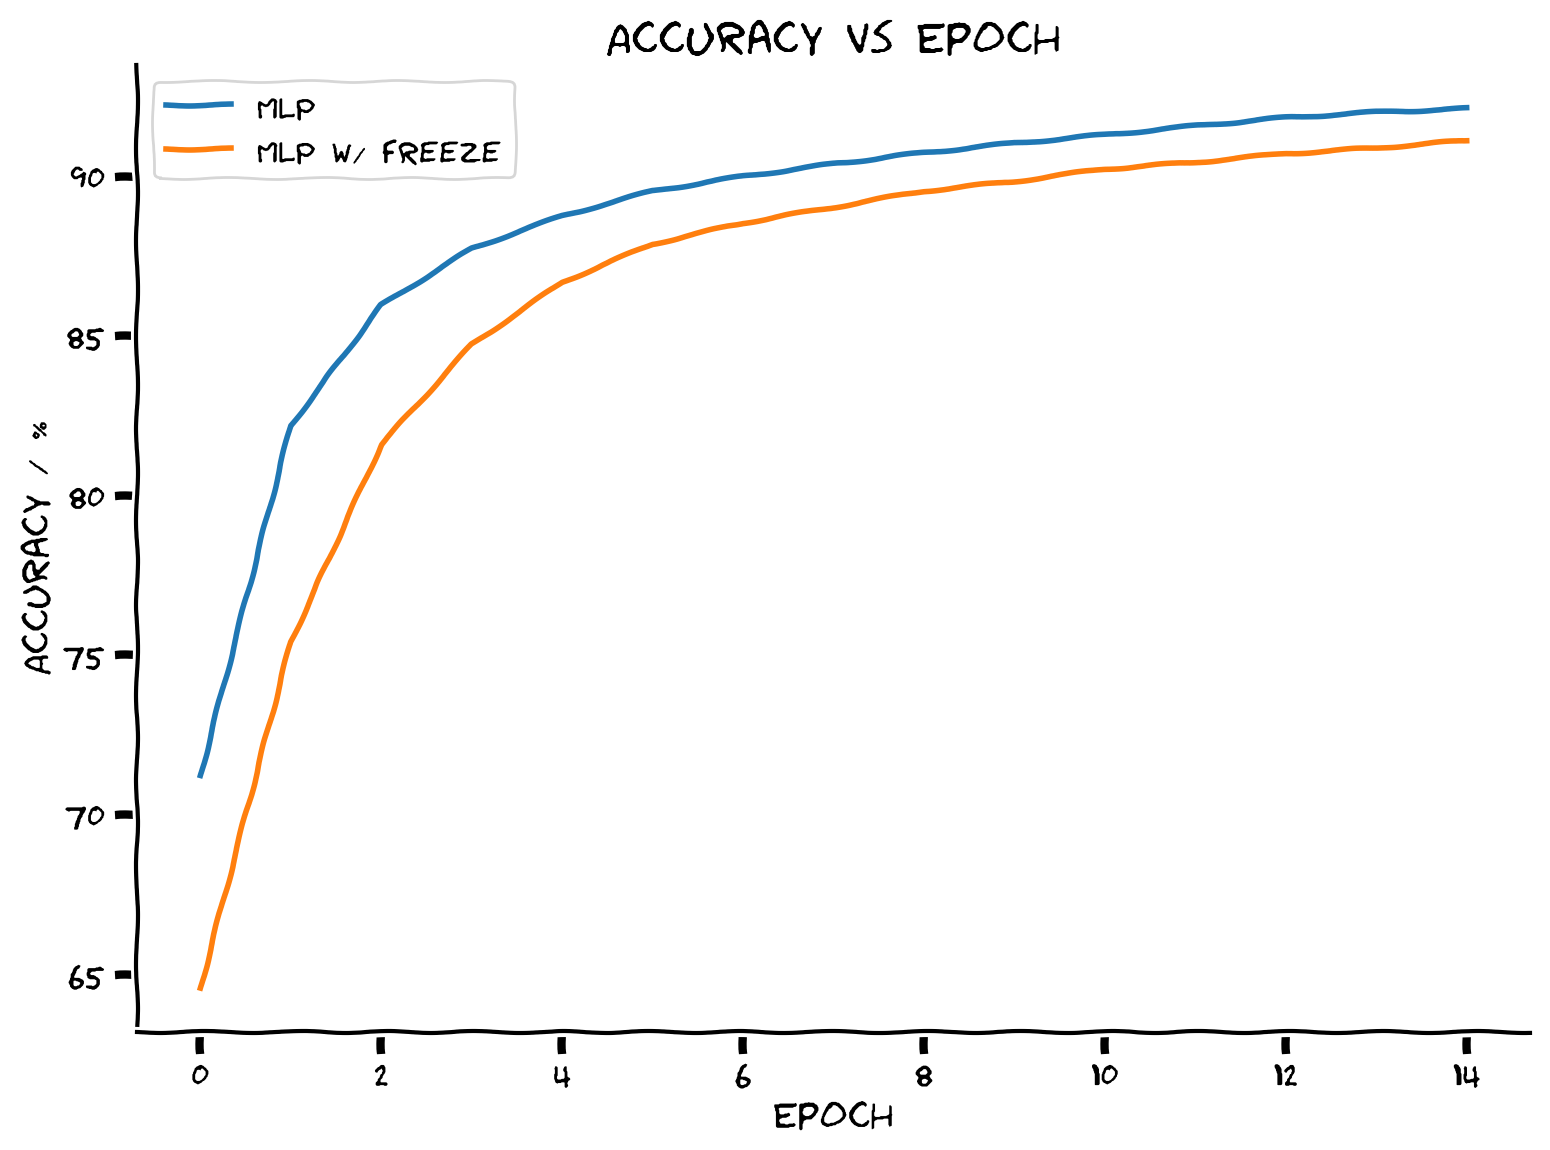

In [22]:
with plt.xkcd():
  plt.plot(model_acc, label='MLP')
  plt.plot(freeze_model_acc, label='MLP w/ freeze')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy / %')
  plt.title('Accuracy vs Epoch')

# RSA Analysis

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


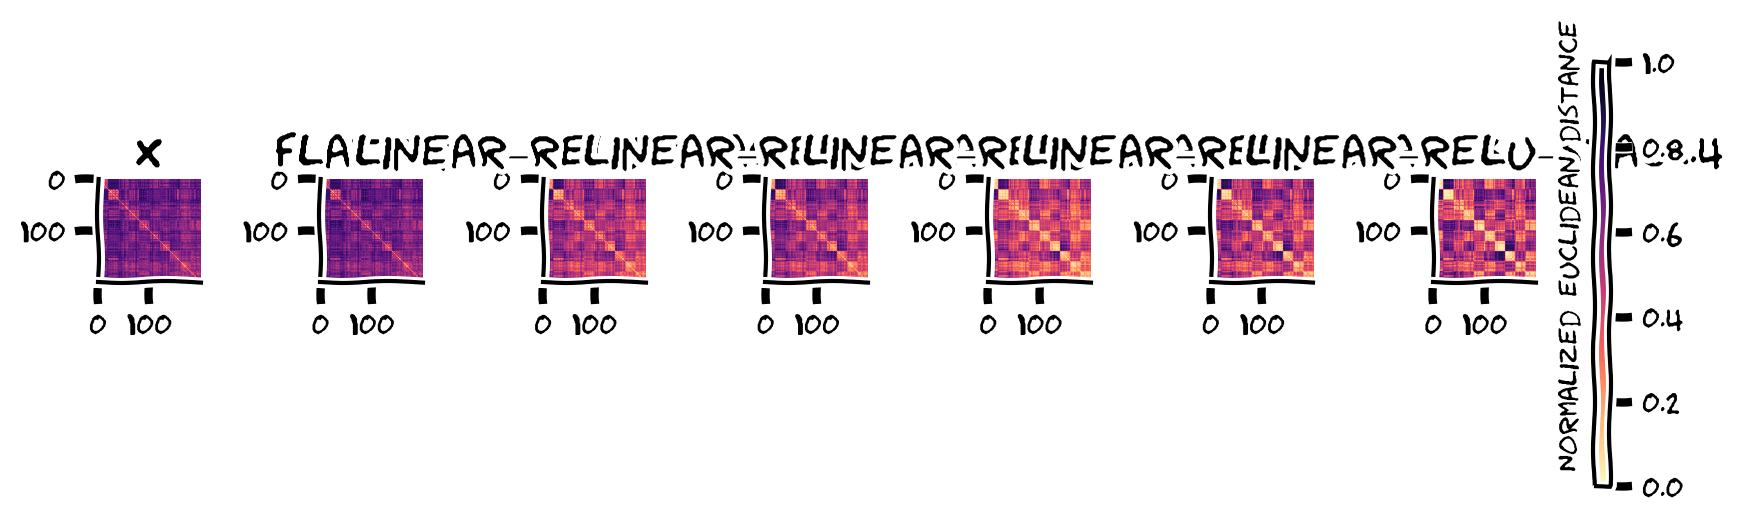

In [24]:
# @title Putting it all together

imgs, labels = sample_images(test_loader, n=20) #grab 20 samples from each category

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
model_features = extract_features(model, imgs.to(device), return_layers='all')

rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


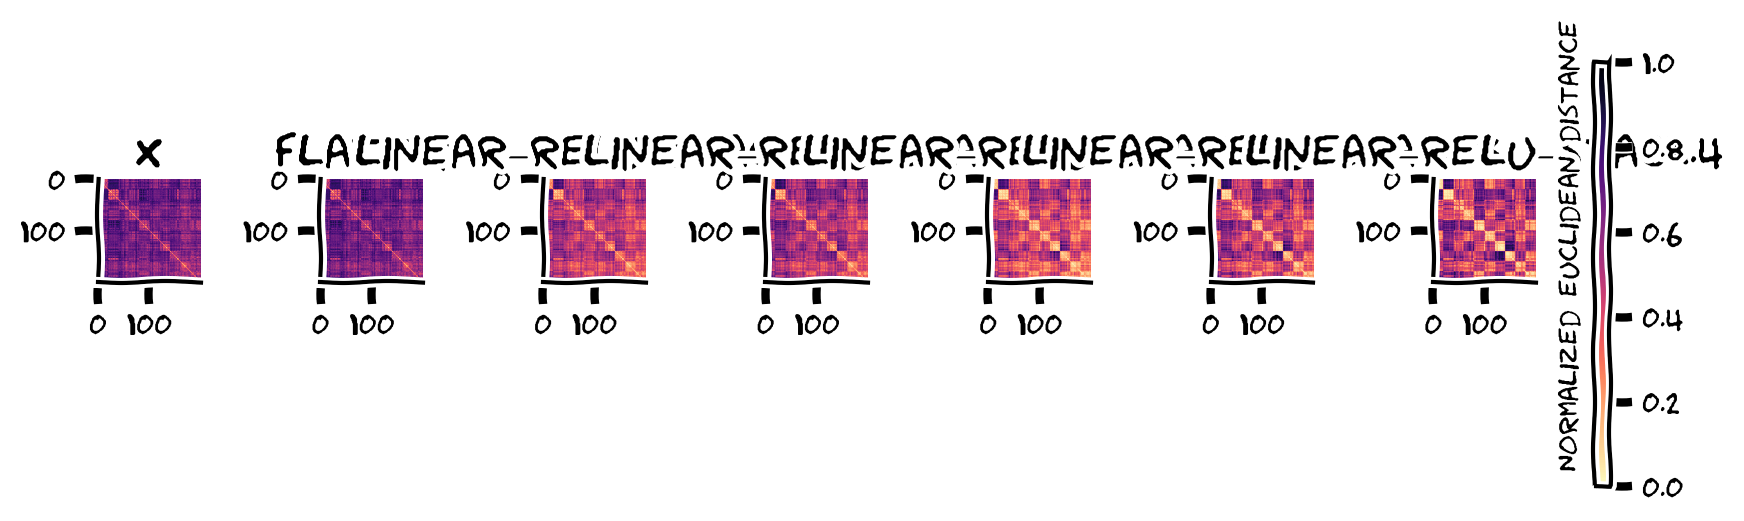

In [30]:
# @title Putting it all together

imgs, labels = sample_images(test_loader, n=20) #grab 20 samples from each category

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
model_features = extract_features(rand_freeze_model, imgs.to(device), return_layers='all')

rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


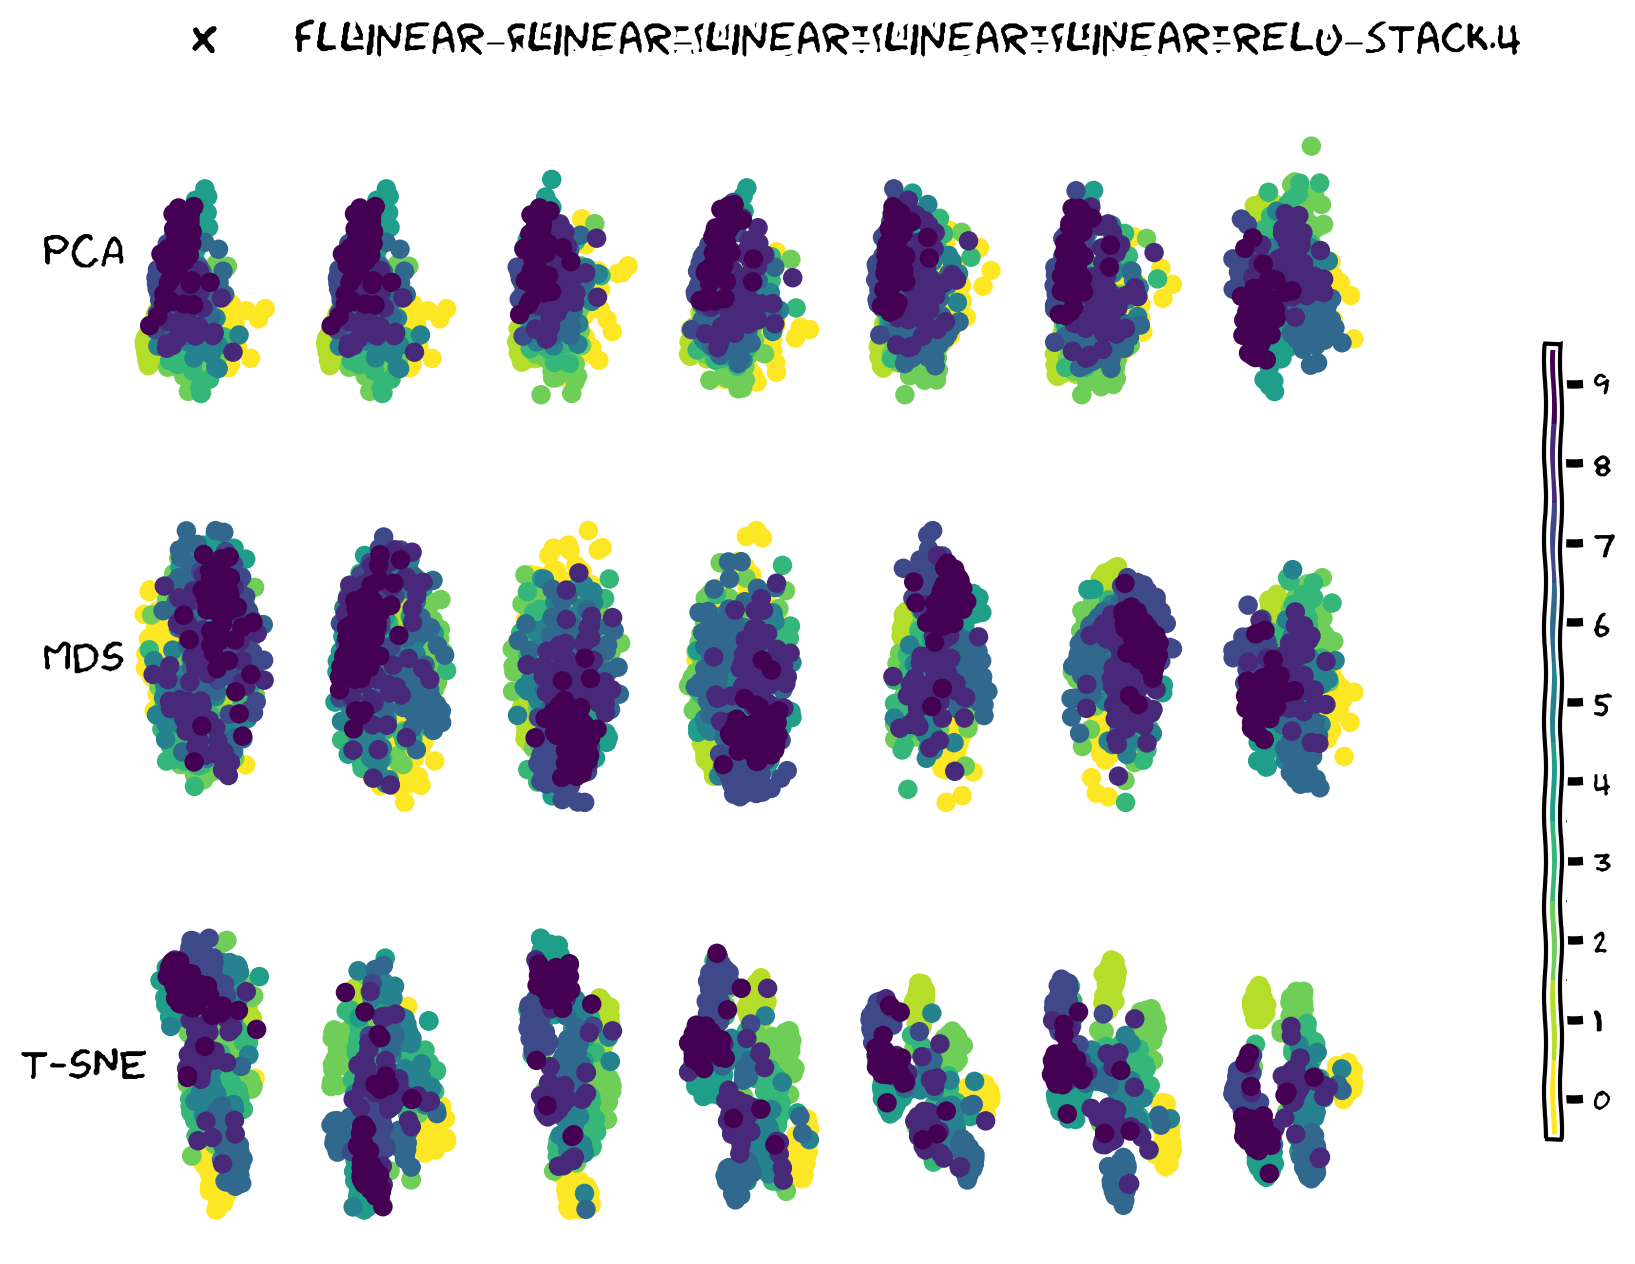

In [31]:
imgs, labels = sample_images(test_loader, n=50) #grab 50 samples from the each category

# Alternatively, get a whole test batch
#imgs, labels = next(iter(test_loader))

model_features = extract_features(model, imgs.to(device), "all")
plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

<ipython-input-4-055384a81970>:119: RuntimeWarning: invalid value encountered in arccos
  rdms_comp = np.arccos(rdms_comp)
<ipython-input-4-055384a81970>:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) miss

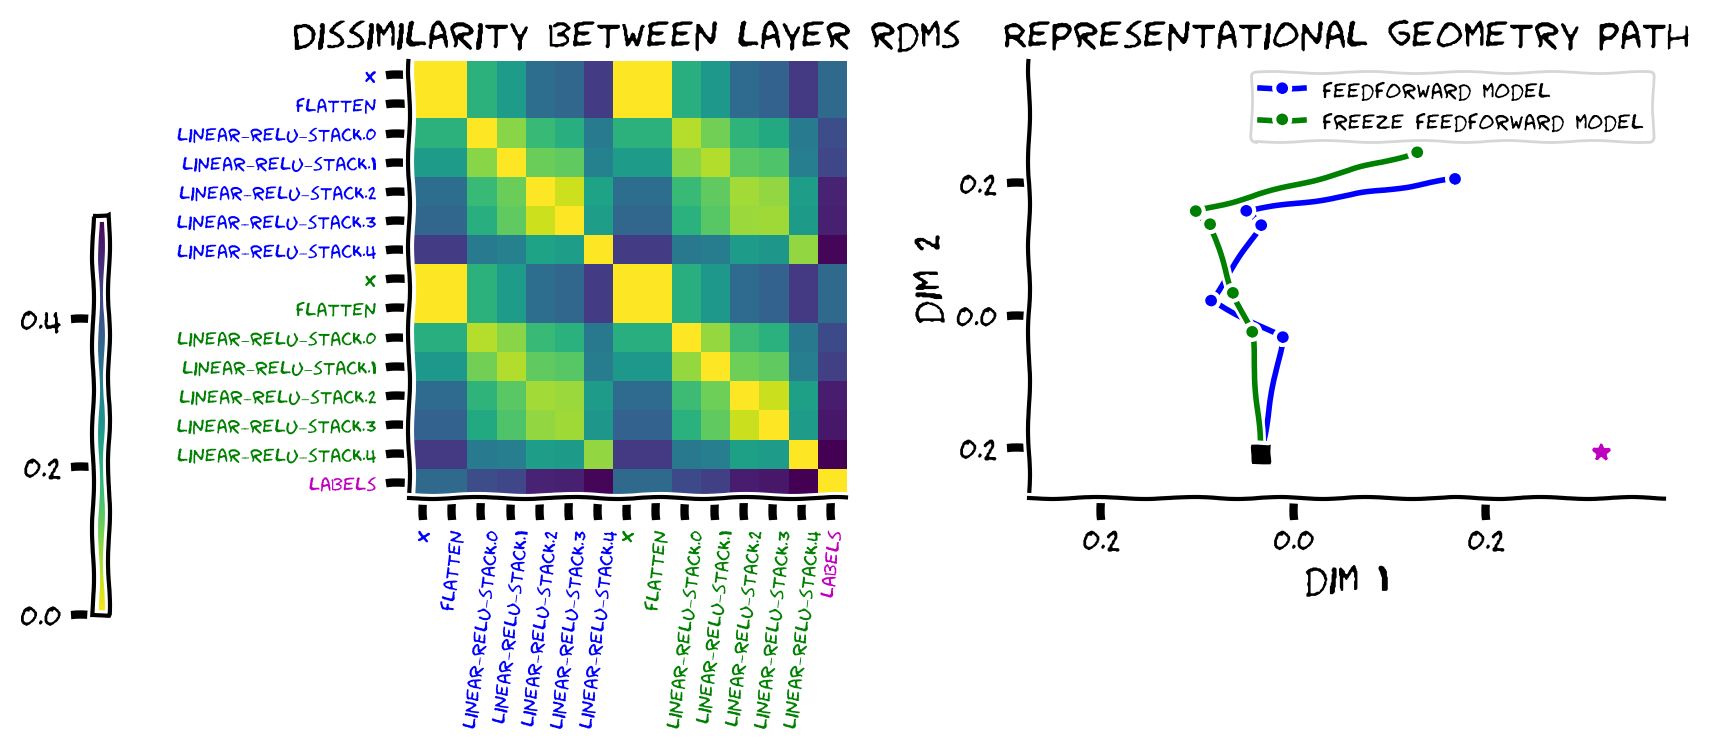

In [44]:
# @title Representational Path

imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=-1)

model_features = extract_features(model, imgs.to(device), return_layers='all')
model_features_freeze = extract_features(rand_freeze_model, imgs.to(device), return_layers='all')

features = {'feedforward model': model_features, 'freeze feedforward model': model_features_freeze}
model_colors = {'feedforward model': 'b', 'freeze feedforward model': 'g'}
rep_path(features, model_colors, one_hot_labels)

In [45]:
one_hot_labels

tensor([[10,  0,  0,  ...,  0,  0,  0],
        [10,  0,  0,  ...,  0,  0,  0],
        [10,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0, 10],
        [ 0,  0,  0,  ...,  0,  0, 10],
        [ 0,  0,  0,  ...,  0,  0, 10]])

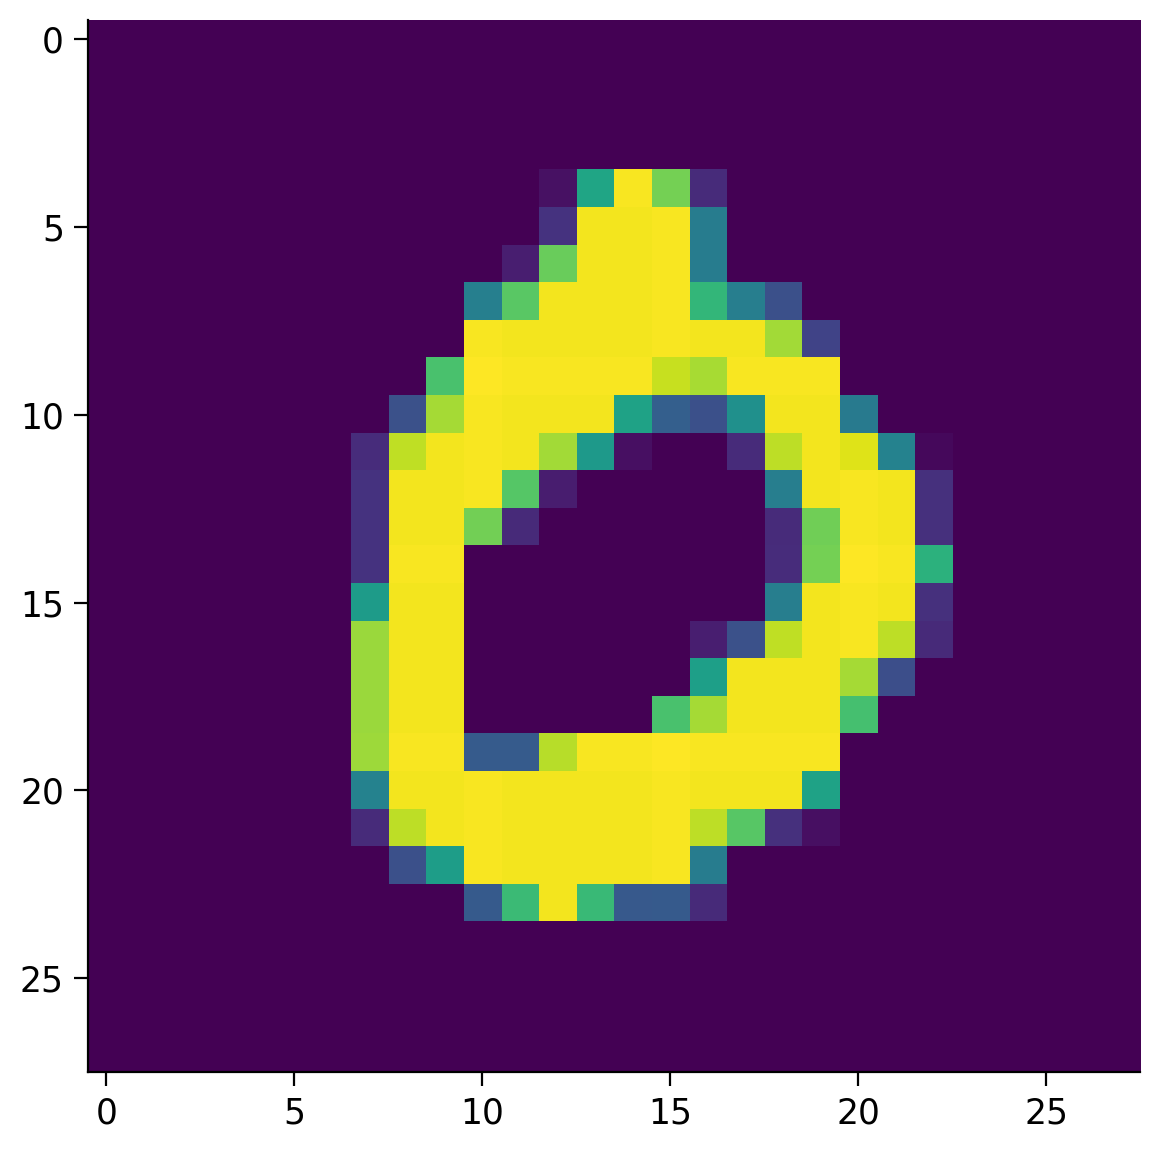

In [37]:
plt.imshow(imgs[0][0])

In [54]:
with torch.no_grad():
  result = model.forward(imgs[0])
  print(result)

tensor([[0.0000, 0.0000, 0.5152, 0.2222, 0.1796, 0.4993, 0.9368, 0.4310, 0.0000,
         0.4496]])
